# Importing Libraries:

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers import Embedding
import warnings
from keras import backend as K
warnings.filterwarnings("ignore")

#### The following block of code will show the detials about the system

In [2]:
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.3.1-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.10 (main, Mar 21 2023, 13:41:05) [Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.2
SciPy 1.10.1
GPU is available


## Reading Data:

In [3]:
train_df = pd.read_csv('train.csv', index_col='id', engine='python')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [4]:
test_df = pd.read_csv('test.csv', index_col='id', engine='python')
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [5]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                       

In [7]:
train_df.isnull().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

In [8]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (1804874, 44) (97320, 1)


## Exploratory Data Analysis

## 1. Target Feature:

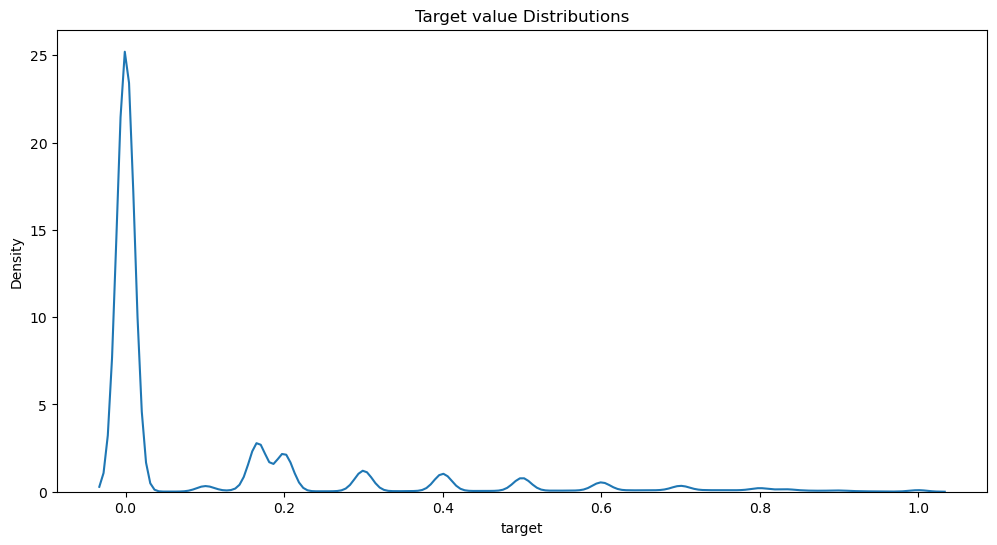

In [9]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

**We see that most of the comments present in the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)**

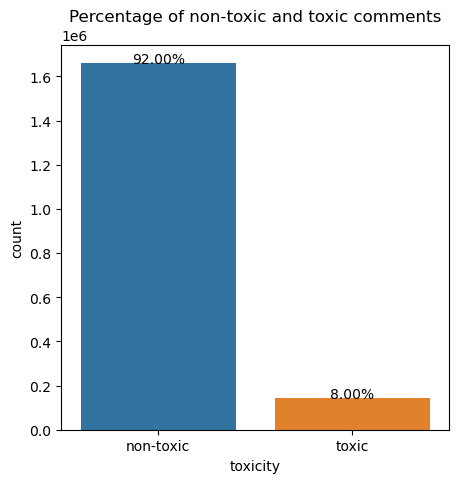

In [10]:
# If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.
# Get toxic and non-toxic comments.
temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")

# Convert to DataFrame and specify column name.
temp_df = temp.to_frame(name='toxicity')

# Plot the number and percentage of toxic and non-toxic comments.
fig, ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(temp))

# Plot the count plot.
cntplot = sns.countplot(data=temp_df, x='toxicity')
cntplot.set_title('Percentage of non-toxic and toxic comments')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()



**The dataset is imbalanced as 92% of the comments are non-toxic and only 8% are toxic**

## 2. Toxicity Subtype Features:
<ul>
<li>severe_toxicity</li>
<li>obscene</li>
<li>threat</li>
<li>insult</li>
<li>identity_attack</li>
</ul>

In [11]:
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

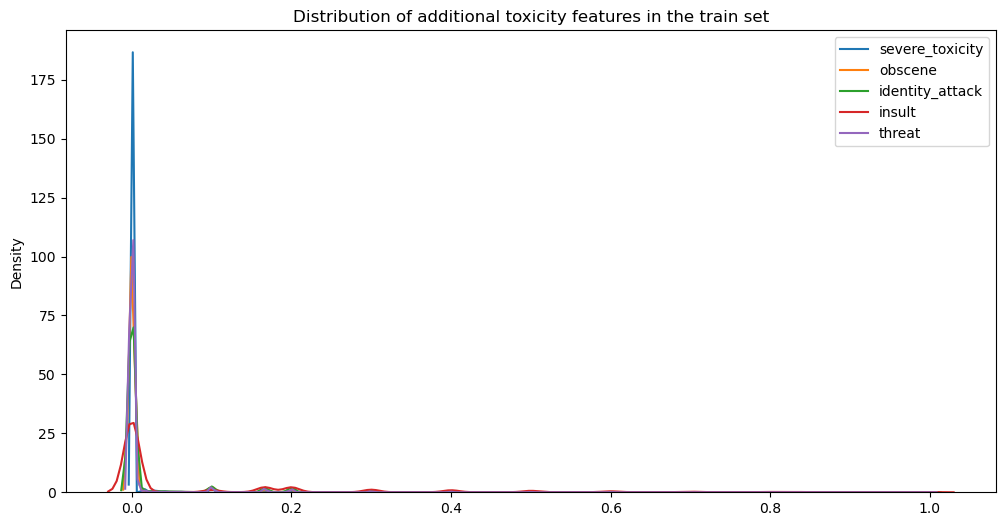

In [12]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set", train_df)

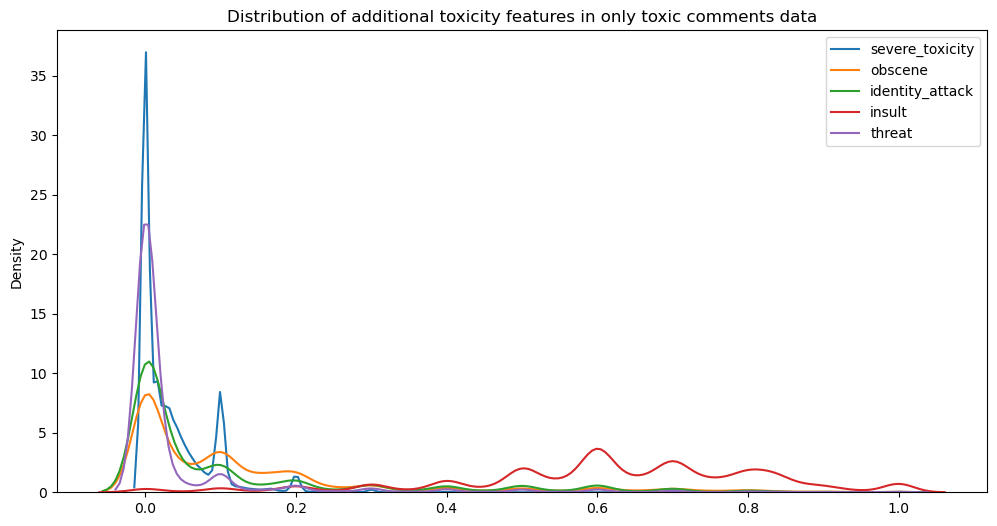

In [13]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train_df[train_df['target'] > 0.5]
plot_features_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

**We see that for toxic comments data, there are more insulting comments as compared to obscene comments**

In [14]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

In [15]:
# If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.
# Get toxic and non-toxic comments.
temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")
print(temp)


id
59848      non-toxic
59849      non-toxic
59852      non-toxic
59855      non-toxic
59856          toxic
             ...    
6333967    non-toxic
6333969    non-toxic
6333982    non-toxic
6334009        toxic
6334010    non-toxic
Name: target, Length: 1804874, dtype: object


In [16]:

# Get nature of each toxic comment
#x = temp[temp == 'toxic'].index.map(lambda i: get_comment_nature(train_df.iloc[i]))
#x


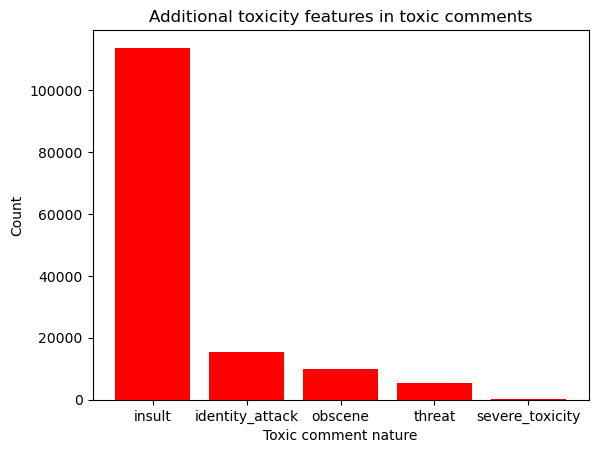

In [17]:
import matplotlib.pyplot as plt

# Get the count of each comment nature
comment_nature_counts = train_df[train_df['target'] >= 0.5].apply(get_comment_nature, axis=1).value_counts()

# Plot the graph
plt.bar(comment_nature_counts.index, comment_nature_counts.values, color='red')

# Set the title and labels
plt.title("Additional toxicity features in toxic comments")
plt.xlabel("Toxic comment nature")
plt.ylabel("Count")

# Display the graph
plt.show()

**In our train dataset only 8% of the data was toxic. Out of that 8%, 81% of the toxic comments made are insults, 8.37% are identity attacks, 7.20% are obscene, 3.35% are threats and a very small amount of toxic comments are severly toxic.**

## 3. Identity Attributes:

Sensitive topics:

- male
- female
- homosexual_gay_or_lesbian
- bisexual
- heterosexual
- christian
- jewish
- muslim
- black
- white
- asian
- latino

In [18]:
temp = train_df.dropna(axis = 0, how = 'any')

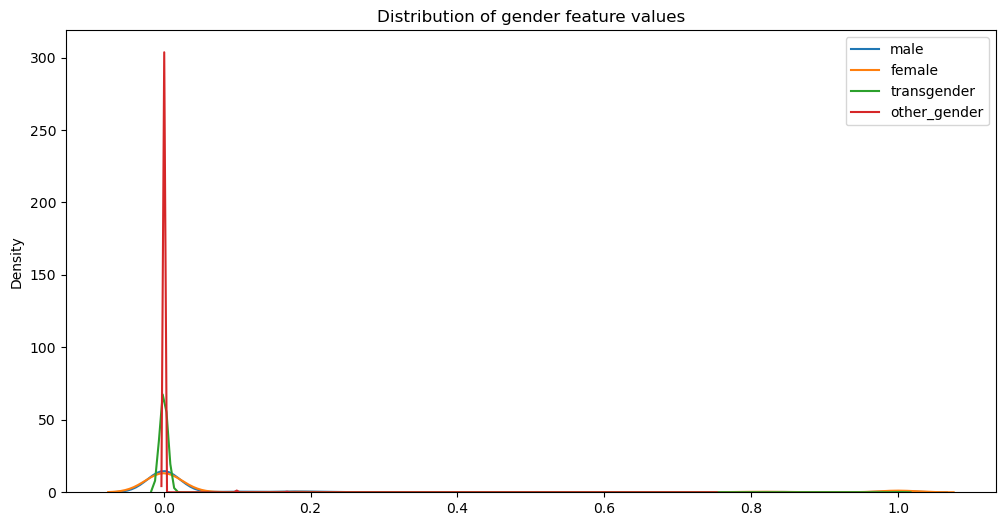

In [19]:
features = ['male', 'female', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender feature values", temp)

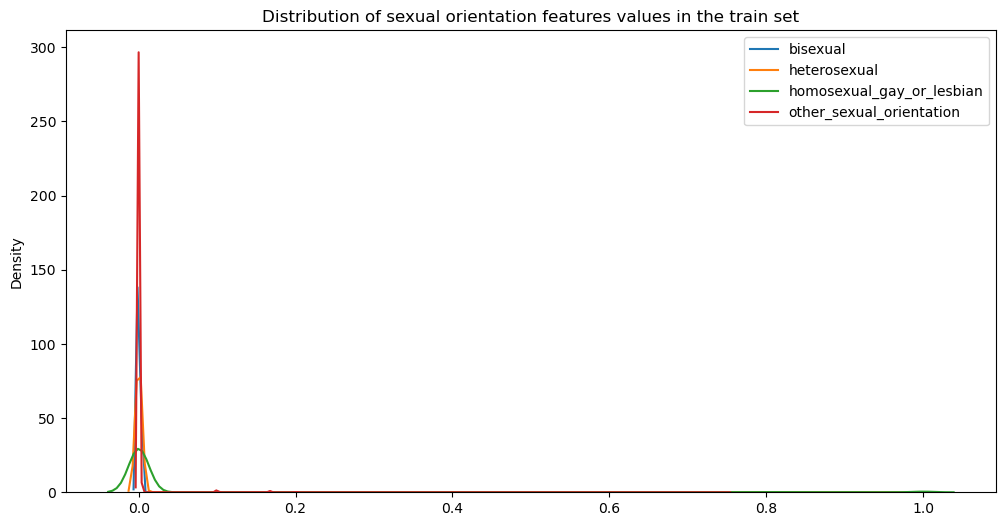

In [20]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_distribution(features, "Distribution of sexual orientation features values in the train set", temp)

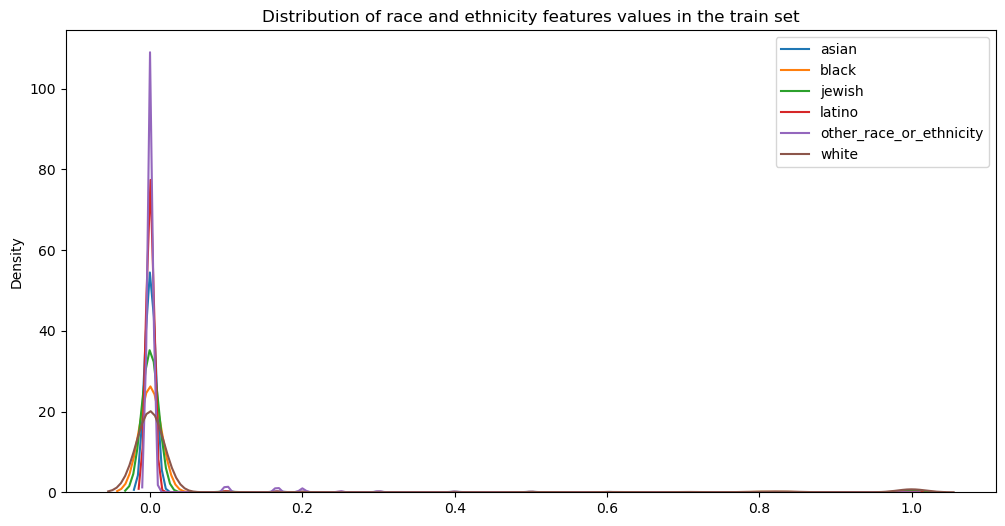

In [21]:
features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set", temp)

In [22]:
# Get data where race/ethnic references are made.
cond = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment


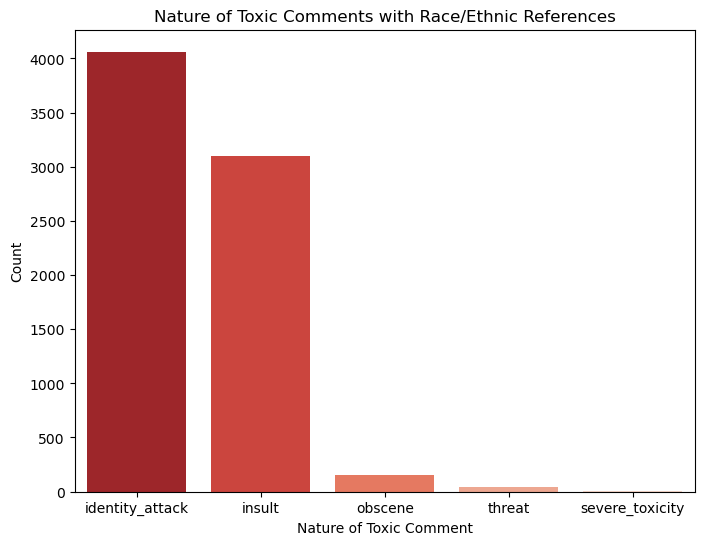

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the nature of each toxic comment
nature_count = x.value_counts()

# Plot the bar graph
plt.figure(figsize=(8,6))
sns.barplot(x=nature_count.index, y=nature_count.values, palette="Reds_r")
plt.title("Nature of Toxic Comments with Race/Ethnic References")
plt.xlabel("Nature of Toxic Comment")
plt.ylabel("Count")
plt.show()

**We see that the toxic comments involving words like black, asian etc. are mainly used for identity attacks or insults.**

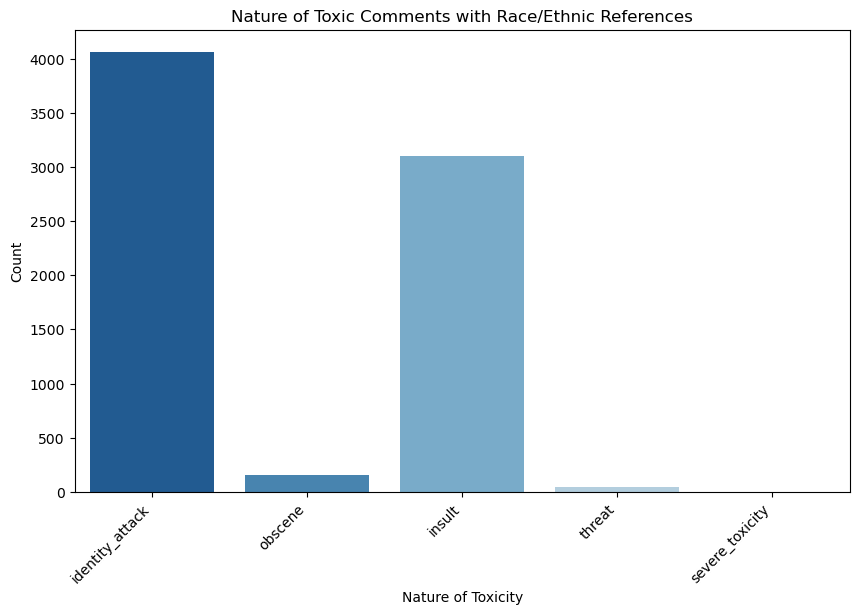

In [24]:
train_df2 = train_df
train_df2['insult'] = pd.to_numeric(train_df['insult'], errors='coerce')

cond = (train_df2['asian'] > 0.5) | (train_df2['black'] > 0.5) | (train_df2['jewish'] > 0.5) | (train_df2['latino'] > 0.5) | (train_df2['white'] > 0.5)
temp = train_df2[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.
temp = temp.reset_index(drop=True) # Reset index of temp DataFrame

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

# Plot the graph
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=x, palette='Blues_r')
ax.set_title("Nature of Toxic Comments with Race/Ethnic References")
ax.set_xlabel("Nature of Toxicity")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()


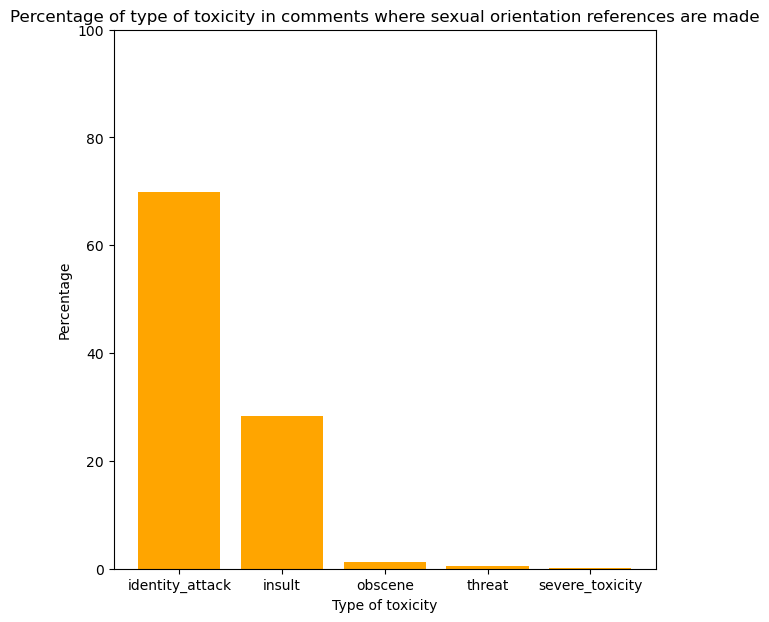

In [25]:
# Get data where sexual orientation references are made.
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
temp = train_df[cond]
temp = temp[temp['target'] > 0.5]

# Get the nature of each toxic comment.
x = temp.apply(get_comment_nature, axis=1)

# Calculate the percentage of each type of toxicity.
percentages = x.value_counts(normalize=True) * 100

# Plot the graph.
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.bar(percentages.index, percentages, color='orange')
ax.set_title("Percentage of type of toxicity in comments where sexual orientation references are made")
ax.set_ylabel("Percentage")
ax.set_xlabel("Type of toxicity")
ax.set_ylim([0,100])
plt.show()


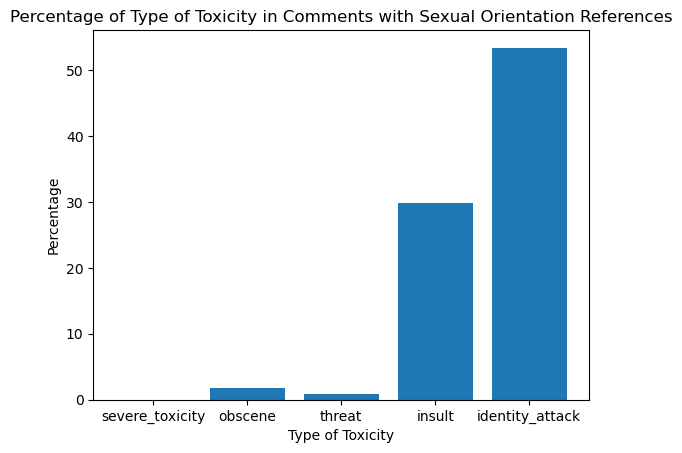

In [26]:
import matplotlib.pyplot as plt

# Define a function to get the percentage of each type of toxicity
def get_toxicity_percentages(df):
    num_comments = len(df)
    percentages = {}
    for toxicity_type in [ 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']:
        num_toxic = len(df[df[toxicity_type] > 0.5])
        percentages[toxicity_type] = num_toxic / num_comments * 100
    return percentages

# Filter the data to only include comments with sexual orientation references and that are toxic
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5)
temp = train_df[cond]
temp = temp[temp['target'] > 0.5]

# Calculate the percentage of each type of toxicity in the filtered data
toxicity_percentages = get_toxicity_percentages(temp)

# Plot a bar chart showing the percentage of each type of toxicity
plt.bar(toxicity_percentages.keys(), toxicity_percentages.values())
plt.xlabel('Type of Toxicity')
plt.ylabel('Percentage')
plt.title('Percentage of Type of Toxicity in Comments with Sexual Orientation References')
plt.show()


**We see from the plot that the toxic comments where sexual orientation references are made are mostly used for identity attacks.** 

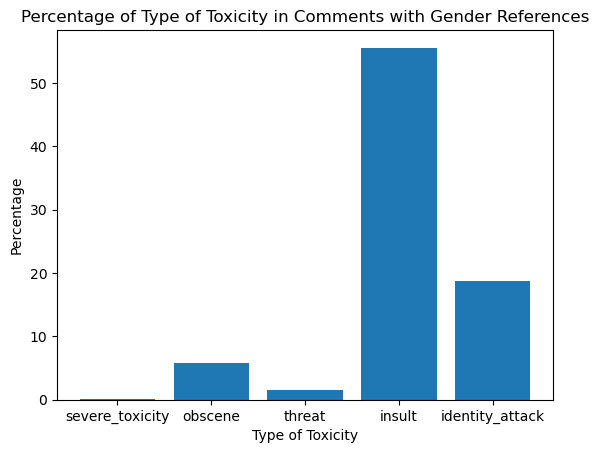

In [27]:
import matplotlib.pyplot as plt

# Define a function to get the percentage of each type of toxicity
def get_toxicity_percentages(df):
    num_comments = len(df)
    percentages = {}
    for toxicity_type in [ 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']:
        num_toxic = len(df[df[toxicity_type] > 0.5])
        percentages[toxicity_type] = num_toxic / num_comments * 100
    return percentages

# Filter the data to only include comments with gender references and that are toxic
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5)
temp = train_df[cond]
temp = temp[temp['target'] > 0.5]

# Calculate the percentage of each type of toxicity in the filtered data
toxicity_percentages = get_toxicity_percentages(temp)

# Plot a bar chart showing the percentage of each type of toxicity
plt.bar(toxicity_percentages.keys(), toxicity_percentages.values())
plt.xlabel('Type of Toxicity')
plt.ylabel('Percentage')
plt.title('Percentage of Type of Toxicity in Comments with Gender References')
plt.show()


**From the plot we see that the toxic comments which involve words like male, female etc are insults.**

## 4. Features generated by users feedback:

- funny
- sad
- wow
- likes
- disagree

In [28]:
''' 
This block of code will result in error for the following graphs

def plot_count(feature, title, data, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(data))
    g = sns.countplot(data[feature], order = data[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()   '''

' \nThis block of code will result in error for the following graphs\n\ndef plot_count(feature, title, data, size=1):\n    f, ax = plt.subplots(1,1, figsize=(4*size,4))\n    total = float(len(data))\n    g = sns.countplot(data[feature], order = data[feature].value_counts().index[:20], palette=\'Set3\')\n    g.set_title("Number and percentage of {}".format(title))\n    for p in ax.patches:\n        height = p.get_height()\n        ax.text(p.get_x()+p.get_width()/2.,\n                height + 3,\n                \'{:1.2f}%\'.format(100*height/total),\n                ha="center") \n    plt.show()   '

In [29]:
def plot_count(feature, title, data, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(data))
    g = sns.countplot(x=feature, data=data, order=data[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.2f}%'.format(100*height/total),ha="center") 
    plt.show()


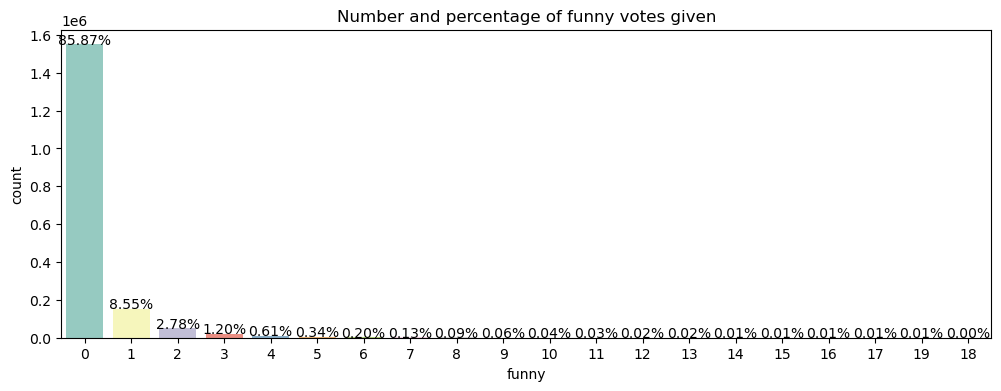

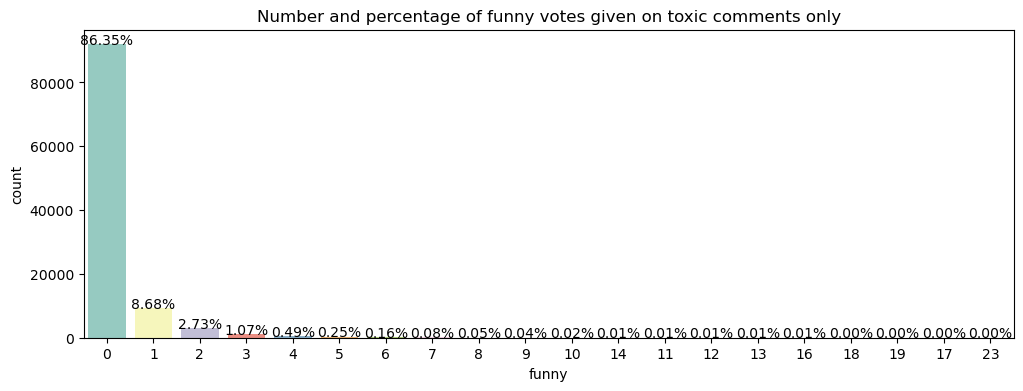

In [30]:
plot_count('funny','funny votes given', train_df, 3)
plot_count('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

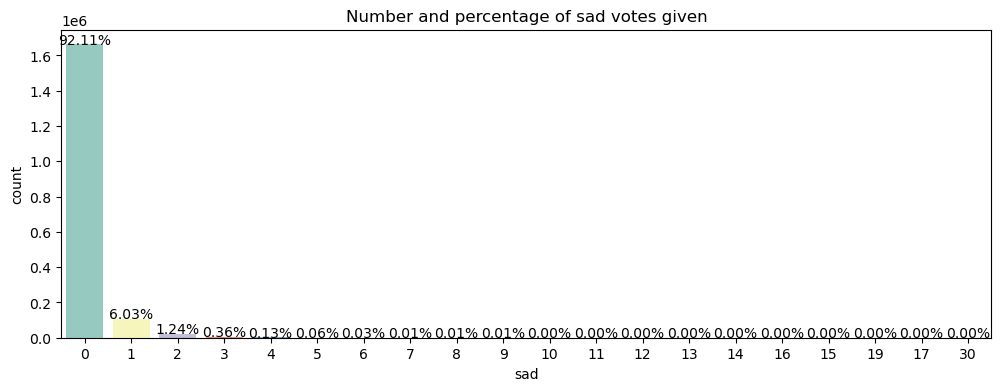

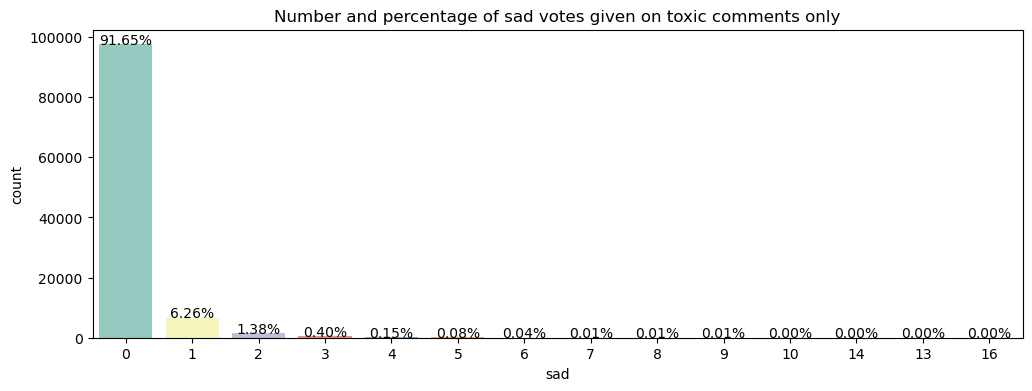

In [31]:
plot_count('sad','sad votes given', train_df, 3)
plot_count('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

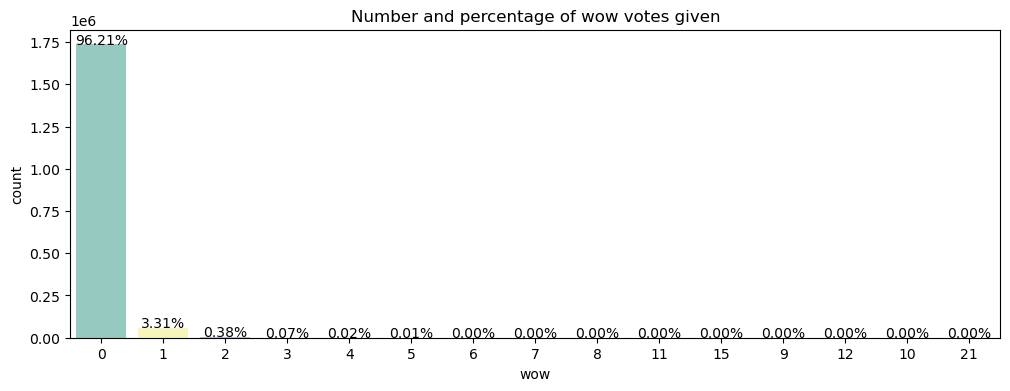

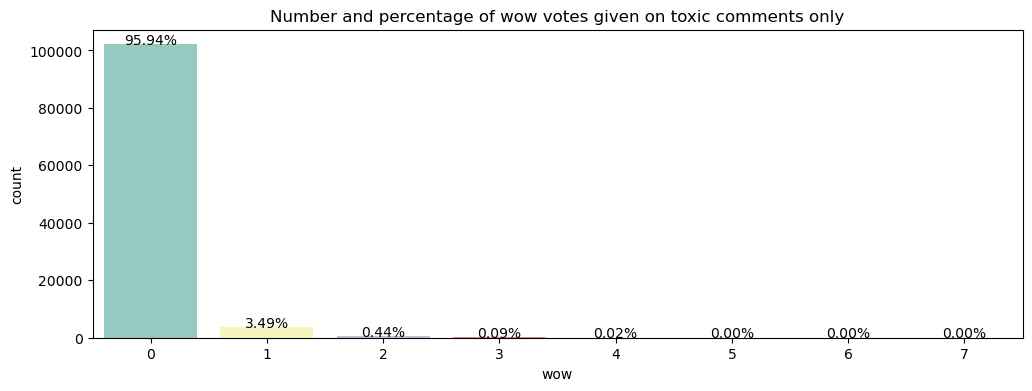

In [32]:
plot_count('wow','wow votes given', train_df, 3)
plot_count('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

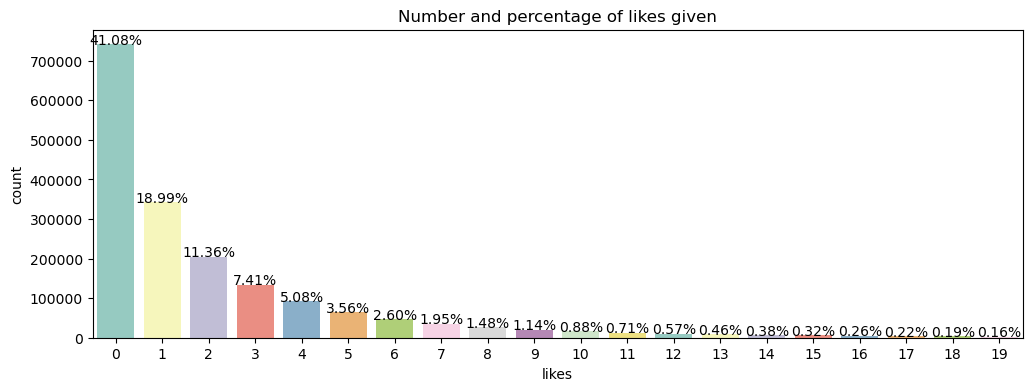

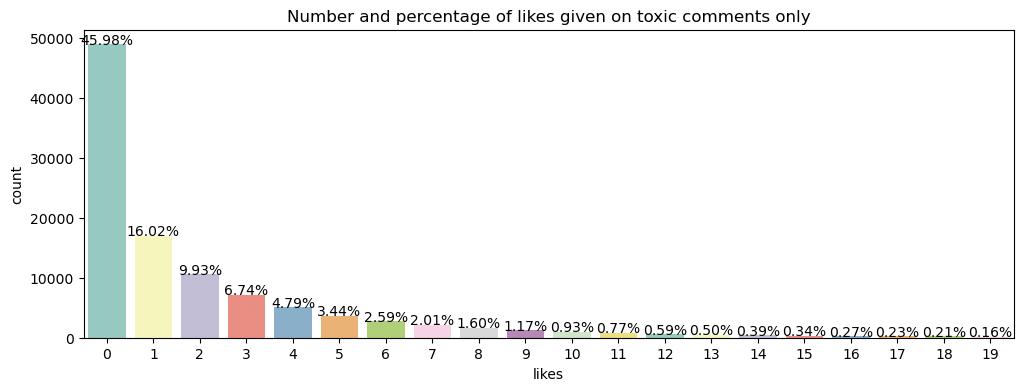

In [33]:
plot_count('likes','likes given', train_df, 3)
plot_count('likes', 'likes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

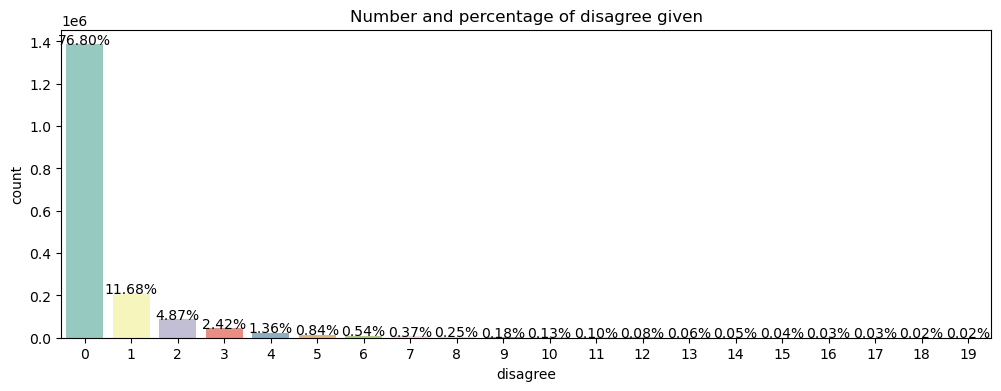

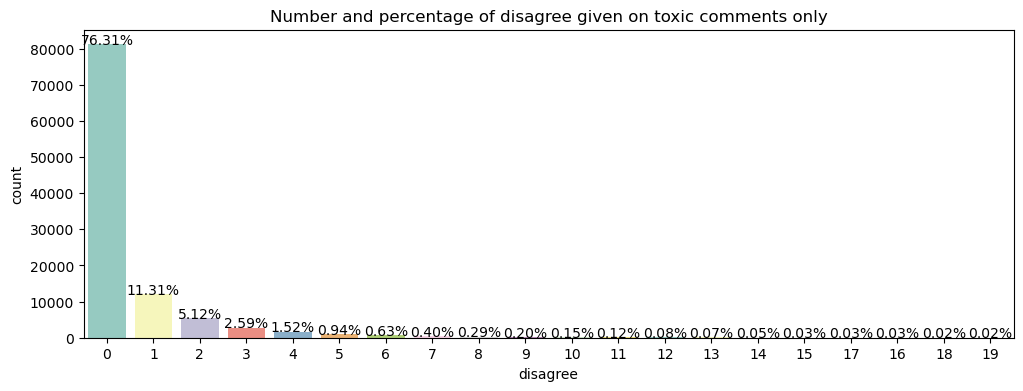

In [34]:
plot_count('disagree','disagree given', train_df, 3)
plot_count('disagree', 'disagree given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

## 5. Comments_text Feature:

In [35]:
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

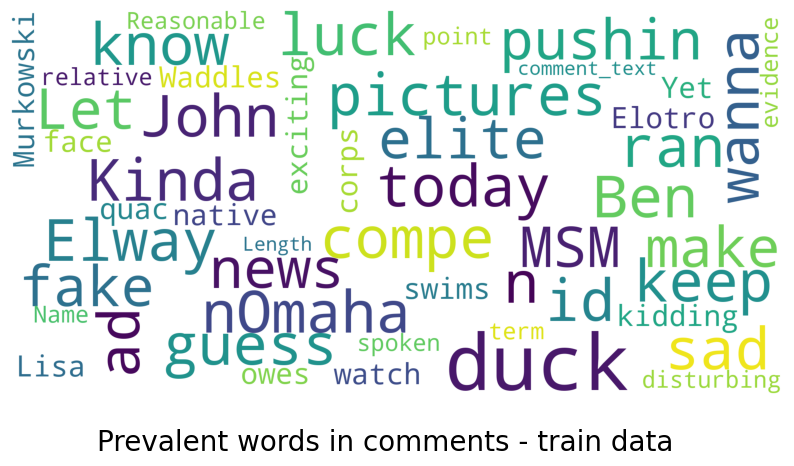

In [36]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

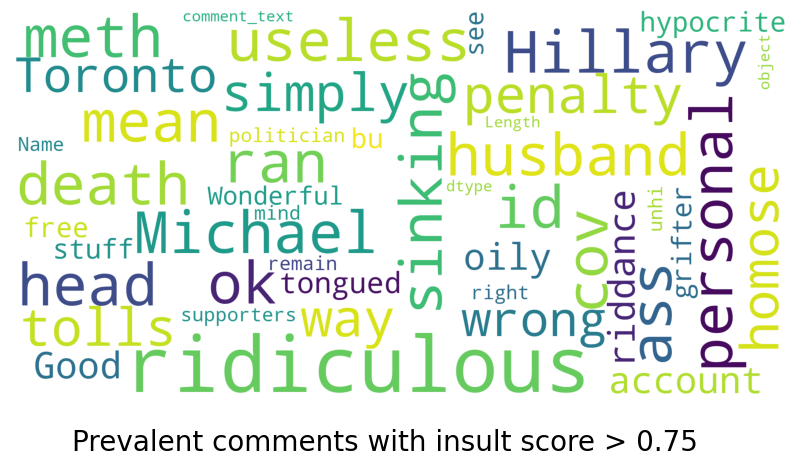

In [37]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75')

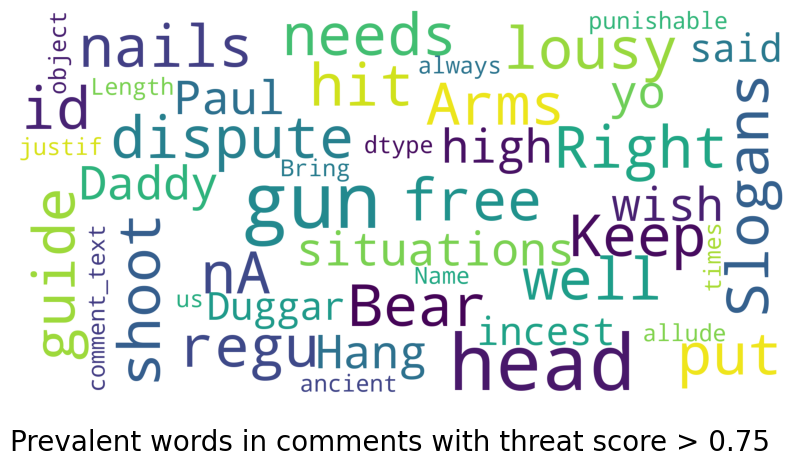

In [38]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with threat score > 0.75')

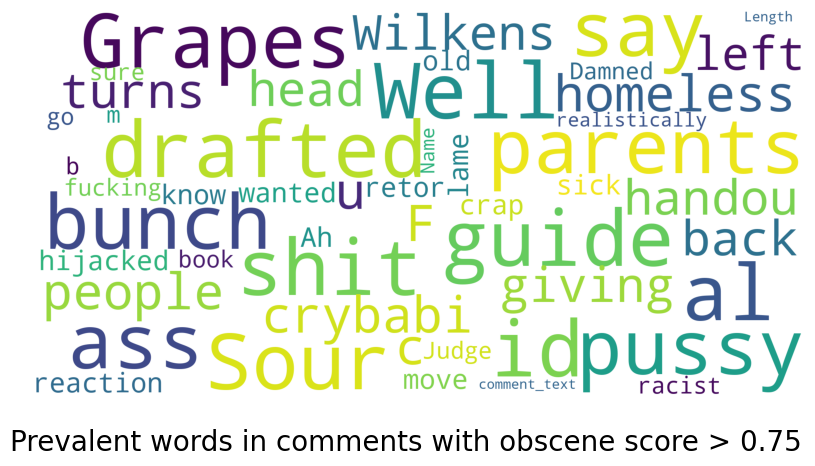

In [39]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

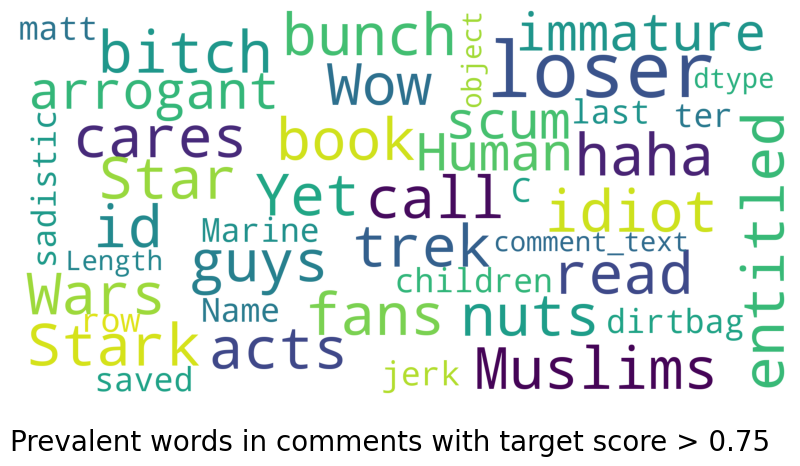

In [40]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

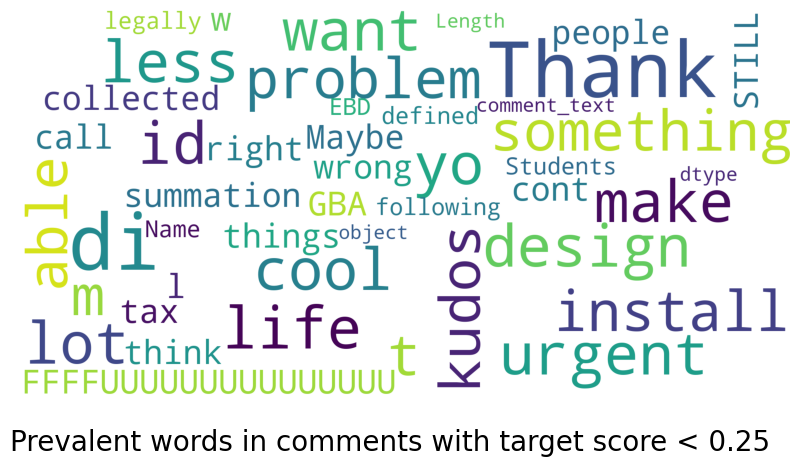

In [41]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

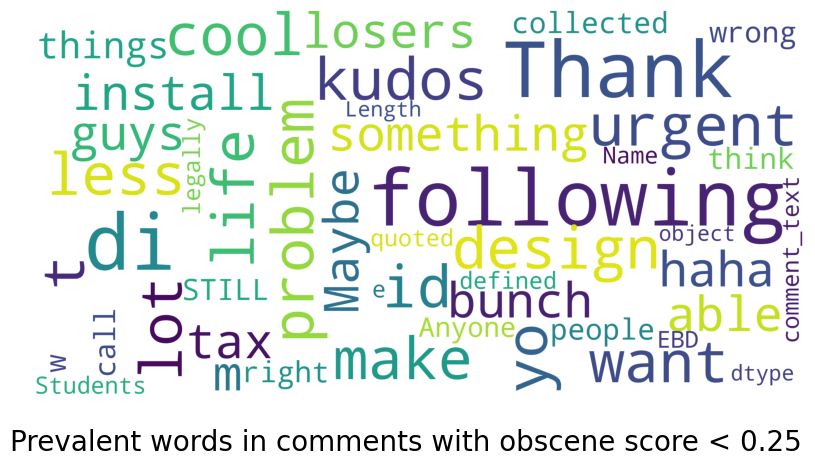

In [42]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')

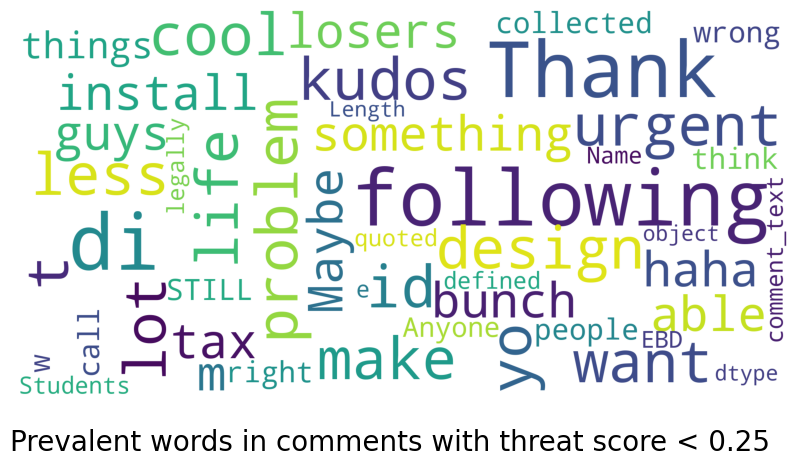

In [43]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')

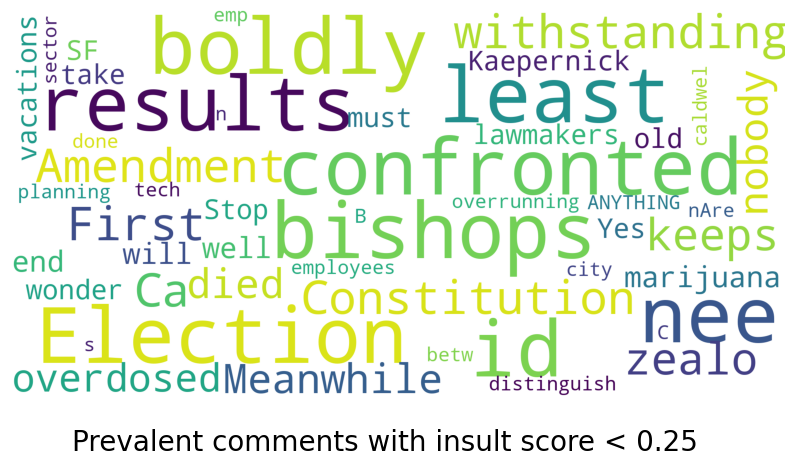

In [44]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')

## Preprocessing Text and Train-Test Split:

In [45]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

In [46]:
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

In [47]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool like would want mother read realli great ...
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank would make life lot less anxieti induc k...
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent design problem kudo take impress
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,someth abl instal site releas
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,haha guy bunch loser


In [48]:
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

In [49]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(1353655, 1)
(451219, 1)
(1353655, 1)
(451219, 1)


In [50]:
X_train.head()

,preprocessed_text
id,
5142661,think peopl vote airport 3 better ever travel ...
6330562,redeem featur presid get real
883306,particular poster resid world altern fact
5172542,dept health handl rat problem downtown honolulu
775347,enjoy retir know extra firework tonight


In [51]:
X_cv.head()

,preprocessed_text
id,
6042743,weed
836923,harper govern approv northern gateway condit a...
5077104,mr troy payn pleas tell citizen best feloni ar...
868618,thought devalu currenc canadian peso play trad...
6274855,realli watch charad fair close seen one iota p...


In [52]:
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


In [53]:
# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

## Training Models:

In [54]:
# To load the csv files:
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

### 1. Bag of Words (BoW):

In [55]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
vectorizer = CountVectorizer()
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


#### 1.1 SGDRegressor:

##### 1.1.1 Hyperparameter Tuning:

In [56]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.15065175341880893
Mean Squared Error on cv set:  0.02957816498385944
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  3.58620679928222
Mean Squared Error on cv set:  0.23109845447757335
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.02451641343290528
Mean Squared Error on cv set:  0.024403824984518645
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  8.698601247793816
Mean Squared Error on cv set:  1.805904495383908
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03147213252585549
Mean Squared Error on cv set:  0.03132296778787472
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.030386499583444852
Mean Squared Error on cv set:  0.0239018925547874
**************************************************
0.

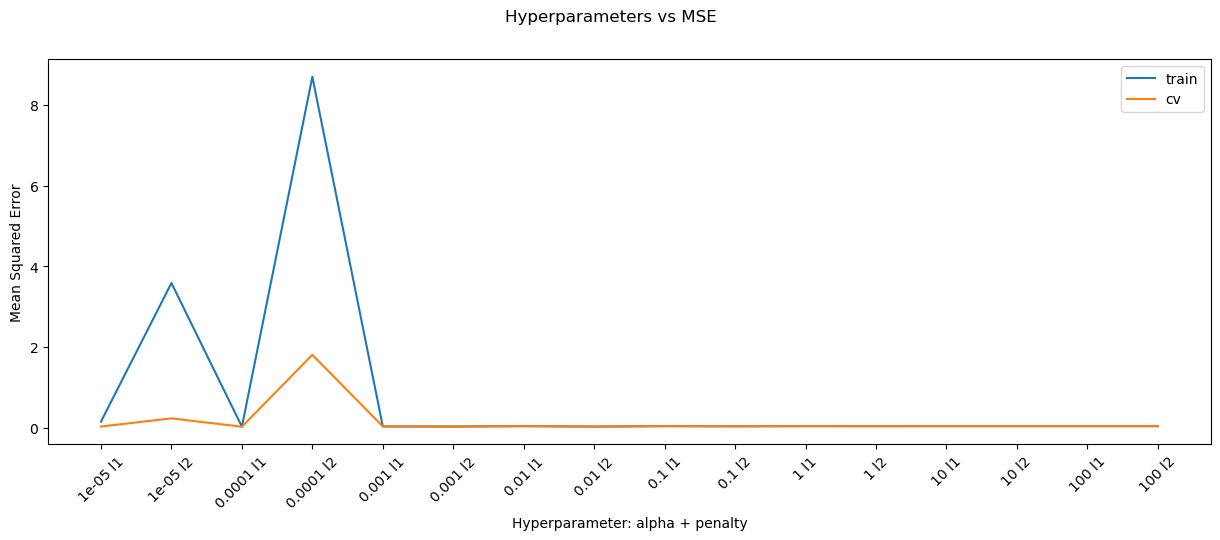

In [57]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [58]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 0.001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_error',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

##### 1.1.2 Feature Importance:

In [59]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

# Printing the 20 most important features/words which contribute to a comment being toxic.
'''feat_names = cnt_vec.get_feature_names_out()
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]
'''

'feat_names = cnt_vec.get_feature_names_out()\nweights = best_model.feature_importances_\ndf = pd.DataFrame(data=weights, columns=[\'weights\'], index=feat_names)\ndf.sort_values("weights", ascending=False).iloc[0:20,:]\n'

In [60]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
stupid stupid,-0.057107
left left,-0.033664
black white,-0.033161
fool peopl,-0.026811
ignor fact,-0.025922
knee jerk,-0.022985
great articl,-0.022486
winner loser,-0.021944
black market,-0.021253
thank,-0.021156


#### 1.2 Decision Trees:

##### 1.2.1 Hyperparameter Tuning:

In [61]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03313298462875006
Mean Squared Error on cv set:  0.03302894924671027
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03313298462875007
Mean Squared Error on cv set:  0.03302894924671028
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03313568044338157
Mean Squared Error on cv set:  0.03302680074595134
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03205373667797802
Mean Squared Error on cv set:  0.03195976186233563
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03205768849162905
Mean Squared Error on cv set:  0.03195892592075731
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train 

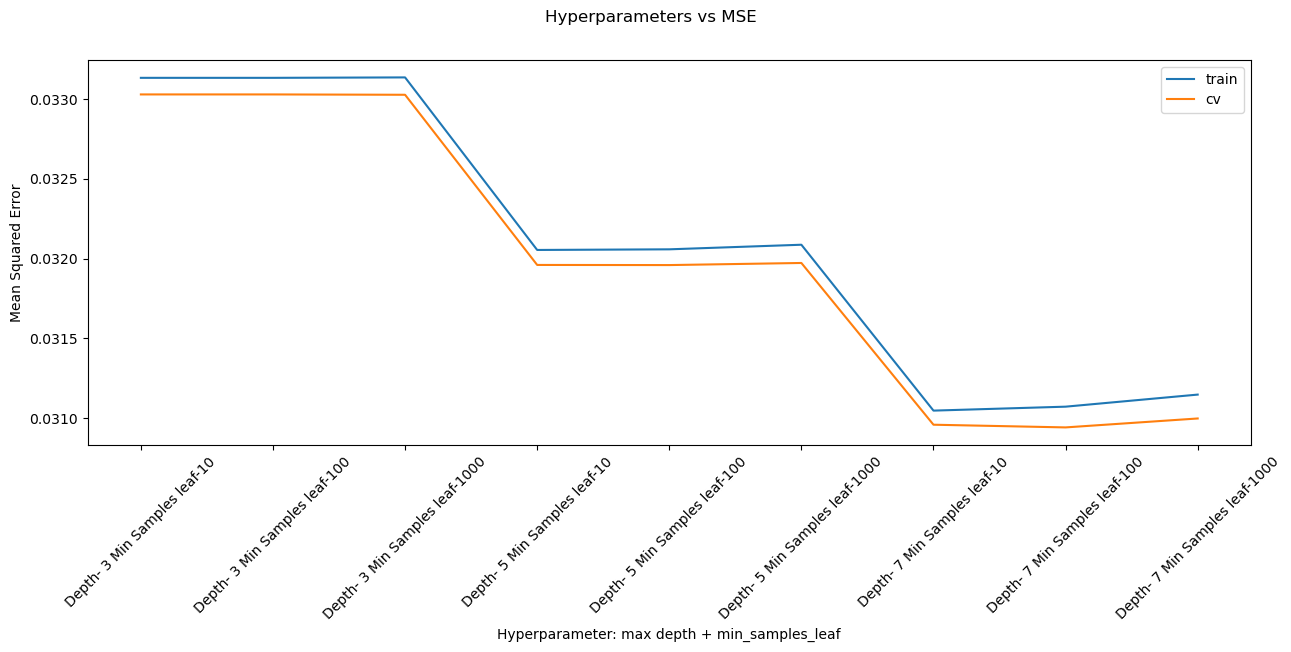

In [62]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [63]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

##### 1.2.2 Feature Importance:

In [64]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.397572
idiot,0.262935
pathet,0.070121
fool,0.068156
moron,0.062549
white,0.058445
hypocrit,0.054983
racist,0.005800
one,0.004606
would,0.004120


### 2. Term Frequency - Inverse Document Frequency (TFIDF) :

In [65]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


#### 2.1 SGDRegressor:

##### 2.1.1 Hyperparameter Tuning:

In [66]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.025280435919366358
Mean Squared Error on cv set:  0.025206813046917097
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.023915958092999283
Mean Squared Error on cv set:  0.023890186574119305
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.029742153869101385
Mean Squared Error on cv set:  0.02963995922849148
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.025036866281302077
Mean Squared Error on cv set:  0.024996408448019095
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03832678793634069
Mean Squared Error on cv set:  0.038132931393494426
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.03008509394487517
Mean Squared Error on cv set:  0.029980521526456107
**************************************

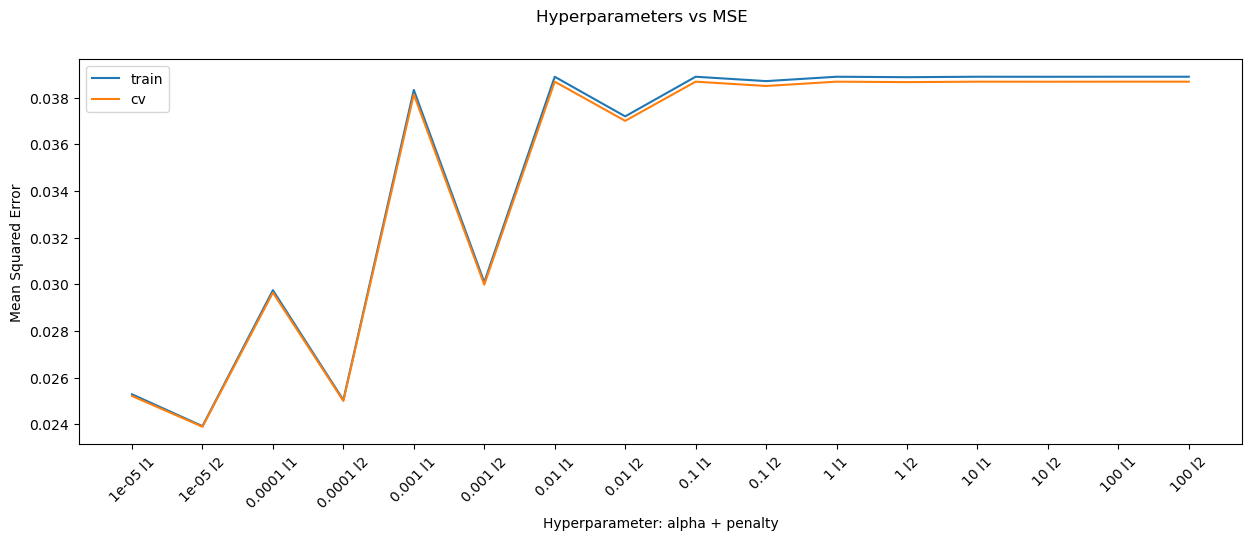

In [67]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.1.2 Feature Importance:

In [68]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names_out()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,1.573779
idiot,1.265893
fool,0.664075
ignor,0.614256
dumb,0.595596
pathet,0.594740
moron,0.572136
ridicul,0.568214
loser,0.564755
liar,0.524785


In [69]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.094503
interest,-0.083377
agre,-0.080200
stori,-0.078429
great,-0.071006
good,-0.070586
may,-0.070051
new,-0.067940
point,-0.067277
work,-0.066807


#### 2.2 Decision Trees:

##### 2.2.1 Hyperparameter Tuning:

In [70]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.032927738478040314
Mean Squared Error on cv set:  0.032826573011590456
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03292773847804032
Mean Squared Error on cv set:  0.032826573011590456
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.032927738478040314
Mean Squared Error on cv set:  0.032826573011590456
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03179432008144781
Mean Squared Error on cv set:  0.03169374494037711
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.0317955063723966
Mean Squared Error on cv set:  0.03169278078097546
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on tr

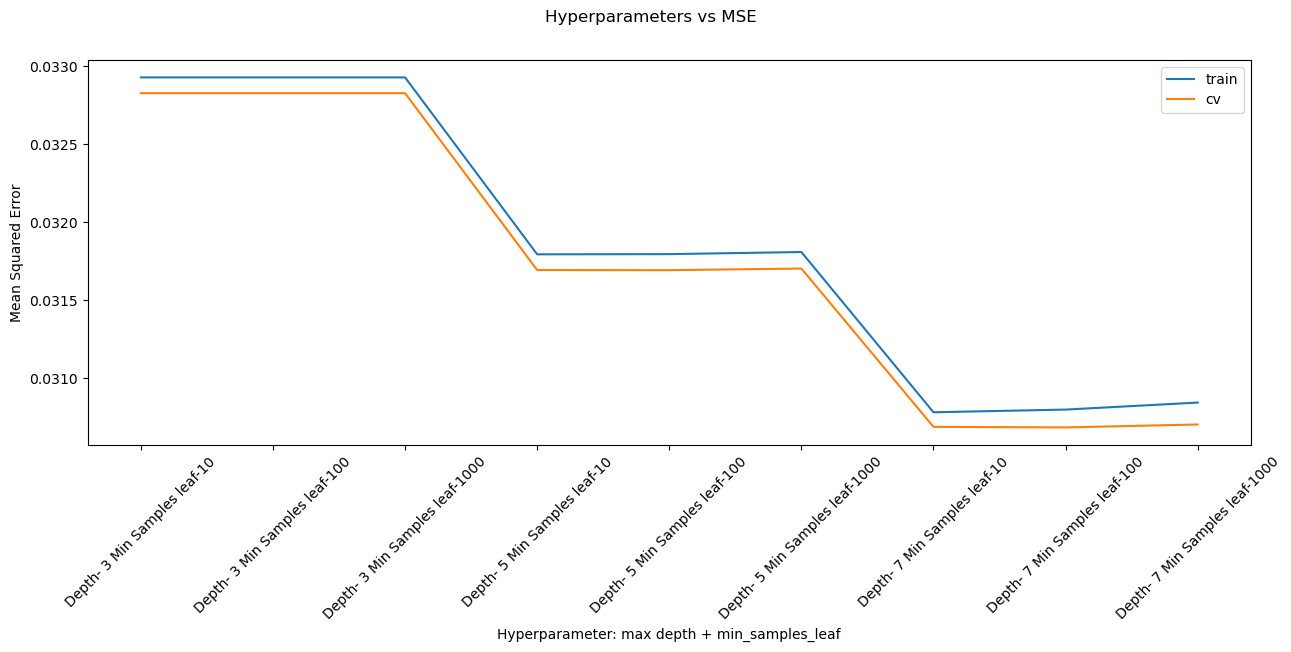

In [71]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

##### 2.2.2 Feature Importance:

In [72]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.407723
idiot,0.266989
pathet,0.071947
fool,0.071402
moron,0.063177
white,0.057472
hypocrit,0.053369
racist,0.005192
trump,0.000895
ignor,0.000618


### 3. Features for LSTM:

In [73]:
from tensorflow.keras.preprocessing import sequence

class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.
        
        # Append additional values to make lengths equal.
        #whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)
        whole = sequence.pad_sequences(np.array(whole), maxlen=pad_length)
        
        return whole

In [74]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

In [75]:
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

In [76]:
print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)

(1353655, 350)
(451219, 350)
(97320, 350)


In [77]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [78]:
# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model.add(CuDNNLSTM(128, return_sequences=True))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 100)          20154400  
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 350, 128)          117760    
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 128)               132096    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 20,404,385
Trainable params: 20,404,385
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [80]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [81]:
history = model.fit(lstm_train, y_train, epochs=5, batch_size=2048, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

Epoch 1/5


2023-05-12 07:13:18.370818: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


661/661 [==============================] - ETA: 0s - loss: 0.0211 - mse: 0.0211
Epoch 1: val_loss improved from -inf to 0.01613, saving model to weights-improvement-01-0.02.hdf5
661/661 [==============================] - 3131s 5s/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0161 - val_mse: 0.0161
Epoch 2/5
661/661 [==============================] - ETA: 0s - loss: 0.0158 - mse: 0.0158
Epoch 2: val_loss did not improve from 0.01613
661/661 [==============================] - 3534s 5s/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0159 - val_mse: 0.0159
Epoch 3/5
661/661 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0152
Epoch 3: val_loss did not improve from 0.01613
661/661 [==============================] - 3667s 6s/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 4/5
661/661 [==============================] - ETA: 0s - loss: 0.0148 - mse: 0.0148
Epoch 4: val_loss did not improve from 0.01613
661/661 [==============================] -

In [84]:
model.save('model.h5')

Text(0.5, 1.0, 'Loss Curves')

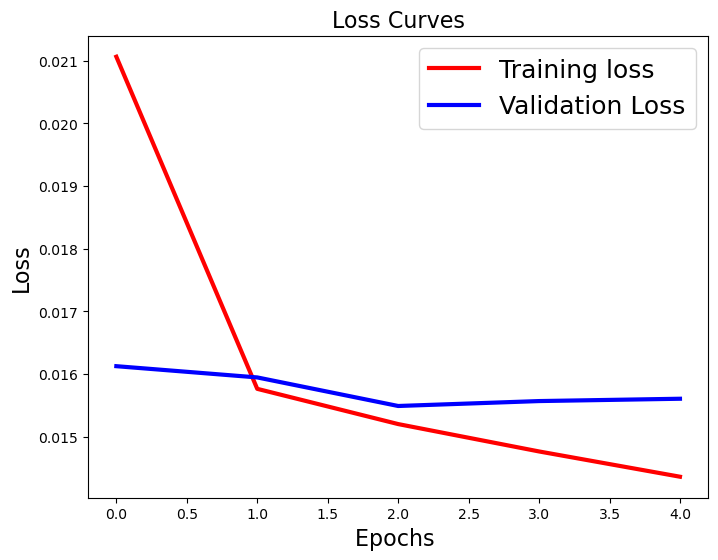

In [86]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [85]:
#inorder to load the model, just un-comment the following line
#model = keras.models.load_model('model.h5')

<br><br><br><br>
<h3><center>End of Assessment task 2 Part B</center><br><br>
<center>by</center>
<center>Hemang Sharma (24695785)</center>
<center>Nusrat Zahan (14367472)</center>
<center>Rajveer Singh Saini (14368005)</center></h3>